In [ ]:
import os
import random
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from torchvision.models import resnet50
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from torch.nn import TripletMarginWithDistanceLoss
import torch.optim as optim
import torch.optim.lr_scheduler as lr_scheduler

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda


In [ ]:
data_dir = "/content/drive/MyDrive/DeepLearning/Final/Datasets/train"

In [ ]:
class TripletFaceDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.classes = sorted(os.listdir(root_dir))
        self.image_paths = {
            cls: [os.path.join(root_dir, cls, img)
                  for img in os.listdir(os.path.join(root_dir, cls))
                  if img.lower().endswith(('jpg', 'jpeg', 'png'))]
            for cls in self.classes
        }

    def __len__(self):
        return sum(len(v) for v in self.image_paths.values())

    def __getitem__(self, idx):
        anchor_class = random.choice(self.classes)
        positive_class = anchor_class
        negative_class = random.choice([c for c in self.classes if c != anchor_class])

        anchor_path = random.choice(self.image_paths[anchor_class])
        positive_path = random.choice([p for p in self.image_paths[positive_class] if p != anchor_path])
        negative_path = random.choice(self.image_paths[negative_class])

        anchor_img = Image.open(anchor_path).convert("RGB")
        positive_img = Image.open(positive_path).convert("RGB")
        negative_img = Image.open(negative_path).convert("RGB")

        if self.transform:
            anchor_img = self.transform(anchor_img)
            positive_img = self.transform(positive_img)
            negative_img = self.transform(negative_img)

        return anchor_img, positive_img, negative_img

In [ ]:
class EmbeddingNet(nn.Module):
    def __init__(self):
        super(EmbeddingNet, self).__init__()
        base_model = resnet50(pretrained=True)
        self.feature_extractor = nn.Sequential(*list(base_model.children())[:-1])
        self.fc = nn.Sequential(
            nn.Linear(2048, 512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, 128),
            nn.LayerNorm(128)
        )

    def forward(self, x):
        x = self.feature_extractor(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        x = F.normalize(x, p=2, dim=1)
        return x

In [ ]:
class TripletNet(nn.Module):
    def __init__(self, embedding_net):
        super(TripletNet, self).__init__()
        self.embedding_net = embedding_net

    def forward(self, anchor, positive, negative):
        anchor_out = self.embedding_net(anchor)
        positive_out = self.embedding_net(positive)
        negative_out = self.embedding_net(negative)
        return anchor_out, positive_out, negative_out

In [ ]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1), scale=(0.8, 1.2)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [ ]:
dataset = TripletFaceDataset(data_dir, transform=transform)
loader = DataLoader(dataset, batch_size=32, shuffle=True, num_workers=2)

In [ ]:
model = TripletNet(EmbeddingNet()).to(device)
def cosine_distance(x1, x2):
    return 1 - F.cosine_similarity(x1, x2, dim=-1)

criterion = TripletMarginWithDistanceLoss(
    distance_function=cosine_distance,
    margin=0.2,
    reduction='mean'
)
optimizer = optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-5)
scheduler = lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 194MB/s]


In [ ]:
def select_hard_triplets(anchor, positive, negative, margin=0.2):
    anchor_out = model.embedding_net(anchor)
    positive_out = model.embedding_net(positive)
    negative_out = model.embedding_net(negative)

    pos_dist = cosine_distance(anchor_out, positive_out)
    neg_dist = cosine_distance(anchor_out, negative_out)

    hard_mask = neg_dist < (pos_dist + margin)

    return anchor[hard_mask], positive[hard_mask], negative[hard_mask]

In [ ]:
epochs = 10
for epoch in range(epochs):
    model.train()
    total_loss = 0.0
    batch_count = 0

    for anchor, positive, negative in loader:
        anchor, positive, negative = anchor.to(device), positive.to(device), negative.to(device)

        anchor, positive, negative = select_hard_triplets(anchor, positive, negative)
        if anchor.size(0) == 0:
            continue

        out_a, out_p, out_n = model(anchor, positive, negative)
        loss = criterion(out_a, out_p, out_n)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        batch_count += 1

    scheduler.step()
    avg_loss = total_loss / batch_count if batch_count > 0 else 0
    print(f"Epoch {epoch+1}/{epochs} - Avg Loss: {avg_loss:.4f}")

Epoch 1/10 - Avg Loss: 0.1707
Epoch 2/10 - Avg Loss: 0.1235
Epoch 3/10 - Avg Loss: 0.1289
Epoch 4/10 - Avg Loss: 0.1225
Epoch 5/10 - Avg Loss: 0.1562
Epoch 6/10 - Avg Loss: 0.1194
Epoch 7/10 - Avg Loss: 0.1309
Epoch 8/10 - Avg Loss: 0.1313
Epoch 9/10 - Avg Loss: 0.1245
Epoch 10/10 - Avg Loss: 0.1395


In [ ]:
torch.save(model.state_dict(), "triplet_face_model_2.pth")

# valid

In [ ]:
model.eval()
with torch.no_grad():
    anchor, positive, negative = next(iter(loader))
    anchor, positive, negative = anchor.to(device), positive.to(device), negative.to(device)

    f1 = model.embedding_net(anchor[0:1]).squeeze().cpu().numpy()
    f2 = model.embedding_net(positive[0:1]).squeeze().cpu().numpy()
    f3 = model.embedding_net(negative[0:1]).squeeze().cpu().numpy()

In [ ]:
print("f1 (anchor embedding):", f1)
print("f2 (positive embedding):", f2)
print("f3 (negative embedding):", f3)

f1 (anchor embedding): [ 1.02233537e-01 -5.35702193e-03 -8.38609338e-02 -9.30401832e-02
 -1.21061973e-01  4.55323309e-02  1.69154733e-01 -1.26161784e-01
  1.61375597e-01 -5.05294055e-02 -1.11955414e-02 -8.42707381e-02
  6.45599067e-02  2.09157363e-01 -6.21110797e-02 -9.77891535e-02
  6.31573498e-02  7.18911961e-02 -1.76483288e-03 -1.12189382e-01
 -2.12718040e-01  9.64175463e-02  6.69315010e-02  3.20692249e-02
 -3.07596829e-02 -6.43313825e-02 -1.50260553e-01 -6.33492023e-02
 -1.17545959e-03 -1.06423385e-01 -1.73555404e-01  1.01661325e-01
 -3.18826474e-02  2.32128929e-02 -1.04985788e-01  7.55217448e-02
  2.19594520e-02  1.14693744e-02 -8.70145950e-03 -1.85974594e-02
 -1.58281028e-02 -3.65541205e-02  8.21146294e-02 -4.88768443e-02
 -3.31745408e-02  7.91125745e-02 -1.45840824e-01 -4.49504703e-03
  1.21166974e-01 -7.10805804e-02 -2.12491155e-02  7.16351718e-02
  1.15495823e-01 -1.28804967e-01  2.87695676e-02 -3.95986252e-02
  3.35271843e-02 -5.11833131e-02  1.37381256e-02 -1.01199016e-01
  

In [ ]:
with torch.no_grad():
    f1 = model.embedding_net(anchor).squeeze().cpu().numpy()
    f2 = model.embedding_net(positive).squeeze().cpu().numpy()
    f3 = model.embedding_net(negative).squeeze().cpu().numpy()

In [ ]:
print("f1 (anchor embedding):", f1)
print("f2 (positive embedding):", f2)
print("f3 (negative embedding):", f3)

f1 (anchor embedding): [[ 0.1022335  -0.00535704 -0.08386097 ... -0.22216238  0.05758737
   0.04014269]
 [-0.10647666 -0.02302599  0.14329812 ... -0.12980318  0.1789056
   0.0332914 ]
 [ 0.09734235 -0.04504921 -0.03122781 ... -0.19444029  0.10101274
   0.04513749]
 ...
 [-0.09376854 -0.02543426  0.1518047  ... -0.12782893  0.19211145
   0.02786857]
 [-0.12015258 -0.09544958 -0.02360561 ...  0.02785923 -0.04824059
   0.00739852]
 [ 0.02163966 -0.05918364  0.16608492 ... -0.06503159  0.07587194
   0.00993976]]
f2 (positive embedding): [[ 0.10593892 -0.00137872 -0.09228358 ... -0.20964634  0.04100833
   0.05247574]
 [-0.10316642 -0.02781793  0.13332407 ... -0.11557603  0.16822223
   0.04371956]
 [ 0.08972408 -0.0208573  -0.07910436 ... -0.20803212  0.06079731
   0.05687289]
 ...
 [-0.12059534 -0.04028934  0.15041518 ... -0.10912272  0.14756817
   0.0414487 ]
 [-0.11770029 -0.11241102 -0.0198745  ...  0.02416428 -0.02618974
   0.01348916]
 [ 0.01773265 -0.05587461  0.16304564 ... -0.061267

In [ ]:
model = TripletNet(EmbeddingNet()).to(device)
model.load_state_dict(torch.load("triplet_face_model_2.pth"))
model.eval()

with torch.no_grad():
    anchor, positive, negative = next(iter(loader))
    anchor, positive, negative = anchor.to(device), positive.to(device), negative.to(device)

    f1 = model.embedding_net(anchor).squeeze().cpu().numpy()
    f2 = model.embedding_net(positive).squeeze().cpu().numpy()
    f3 = model.embedding_net(negative).squeeze().cpu().numpy()

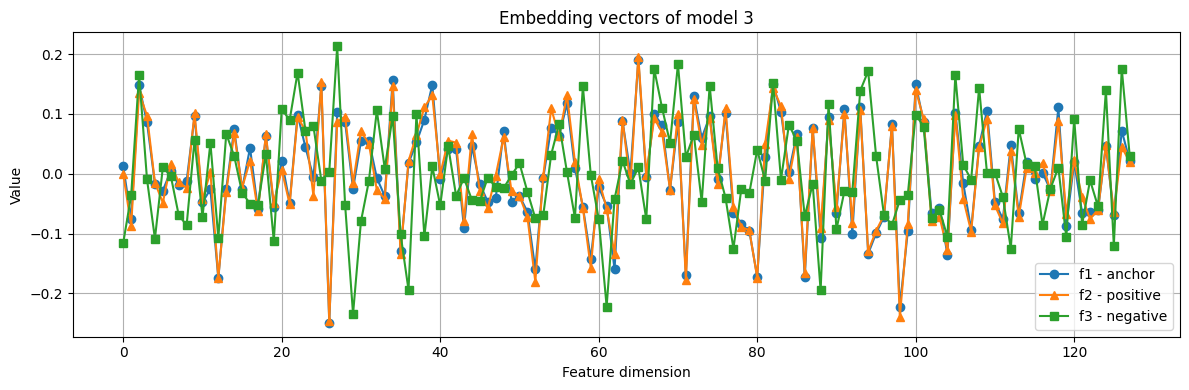

In [ ]:
plt.figure(figsize=(12, 4))
plt.plot(f1[0], label='f1 - anchor', marker='o')
plt.plot(f2[0], label='f2 - positive', marker='^')
plt.plot(f3[0], label='f3 - negative', marker='s')
plt.title("Embedding vectors of model 3")
plt.xlabel("Feature dimension")
plt.ylabel("Value")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
sim_ap = F.cosine_similarity(torch.tensor(f1), torch.tensor(f2), dim=1)
sim_an = F.cosine_similarity(torch.tensor(f1), torch.tensor(f3), dim=1)
print(f"Cosine Similarity (anchor vs positive): {sim_ap.mean().item():.4f}")
print(f"Cosine Similarity (anchor vs negative): {sim_an.mean().item():.4f}")

Cosine Similarity (anchor vs positive): 0.9683
Cosine Similarity (anchor vs negative): 0.2111


3d

In [ ]:
from sklearn.manifold import TSNE
from mpl_toolkits.mplot3d import Axes3D

embeddings = []
labels = []  # 0 - anchor, 1 - positive, 2 - negative

model.eval()
with torch.no_grad():
    for i in range(50):  # lấy 50 batch hoặc bao nhiêu tuỳ bạn
        anchor, positive, negative = next(iter(loader))
        anchor = anchor.to(device)
        positive = positive.to(device)
        negative = negative.to(device)

        emb_a = model.embedding_net(anchor).cpu().numpy()
        emb_p = model.embedding_net(positive).cpu().numpy()
        emb_n = model.embedding_net(negative).cpu().numpy()

        embeddings.extend(emb_a)
        embeddings.extend(emb_p)
        embeddings.extend(emb_n)

        labels.extend([0] * len(emb_a))  # anchor
        labels.extend([1] * len(emb_p))  # positive
        labels.extend([2] * len(emb_n))  # negative


/usr/local/lib/python3.11/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


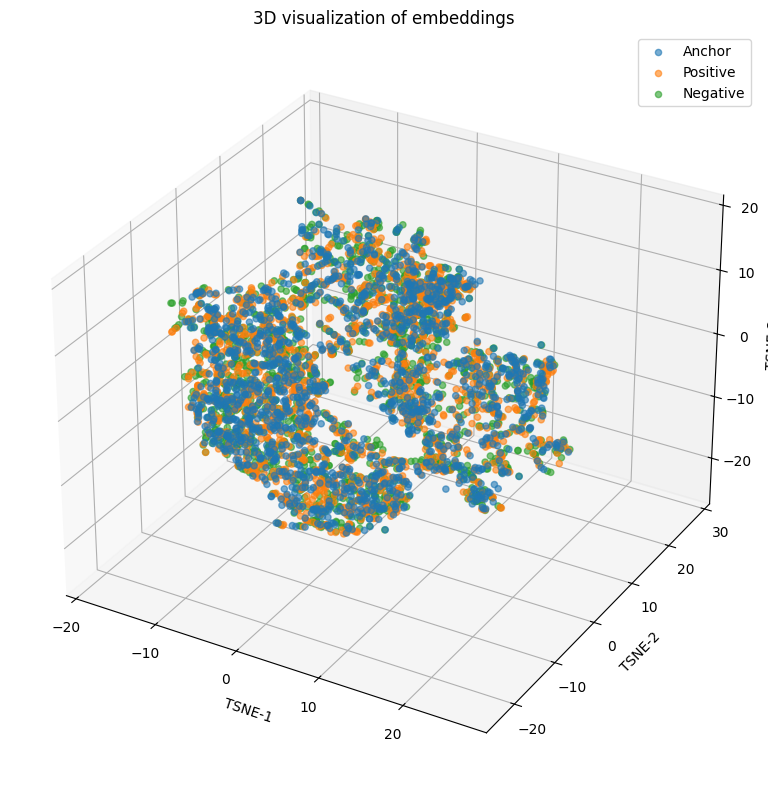

In [ ]:
# Sử dụng t-SNE 3D
tsne = TSNE(n_components=3, perplexity=30, learning_rate=200, n_iter=1000, random_state=42)
emb_3d = tsne.fit_transform(np.array(embeddings))

# Vẽ biểu đồ 3D
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

colors = ['blue', 'orange', 'green']
labels_text = ['Anchor', 'Positive', 'Negative']

for label_id in range(3):
    idx = [i for i, l in enumerate(labels) if l == label_id]
    ax.scatter(
        emb_3d[idx, 0],
        emb_3d[idx, 1],
        emb_3d[idx, 2],
        label=labels_text[label_id],
        alpha=0.6,
        s=20
    )

ax.set_title("3D visualization of embeddings")
ax.set_xlabel("TSNE-1")
ax.set_ylabel("TSNE-2")
ax.set_zlabel("TSNE-3")
ax.legend()
plt.tight_layout()
plt.show()
